In [2]:
import yfinance as yf
import pandas as pd
import polars as pl


In [3]:
hn_df = pl.scan_parquet("./data/hacker_news_full_*.parquet", )


## Queries to match tokens

In [4]:
# Count non-null titles by type
hn_df.groupby("type").agg([pl.count("title").alias("title_count")]).sort(
    "title_count", reverse=True
).collect()


type,title_count
str,u32
"""comment""",13910143
"""story""",2259361
"""job""",7699
"""pollopt""",6762
"""poll""",970


In [5]:
# Create a mapping of matching strings to search in the title of hn_df
queries = {
    "btc": ["bitcoin", "btc"],
    "eth": ["ethereum", "eth"],
    "xrp": ["ripple", "xrp"],
    "ltc": ["litecoin", "ltc"],
    "sol": ["solana", "sol"],
}
# Use queries to create new "{token}_matched"columns in hn_df
for token, query in queries.items():
    joined_query_str = "|".join(
        [f" {subquery} " for subquery in query]
    )  # spaces to match whole word only
    hn_df = hn_df.with_columns(
        [
            pl.col("title")
            .str.to_lowercase()
            .str.contains(joined_query_str)
            .alias(f"{token}_matched_title"),
            pl.col("url")
            .str.to_lowercase()
            .str.contains(joined_query_str)
            .alias(f"{token}_matched_url"),
            pl.col("text")
            .str.to_lowercase()
            .str.contains(joined_query_str)
            .alias(f"{token}_matched_text"),
        ]
    ).with_columns(
        (
            pl.col(f"{token}_matched_title")
            | pl.col(f"{token}_matched_url")
            | pl.col(f"{token}_matched_text")
        ).alias(f"{token}_matched")
    )


# Preview: Count how many matches there are for each token
_ = hn_df.select(
    [
        pl.col("btc_matched").sum().alias("BTC"),
        pl.col("eth_matched").sum().alias("ETH"),
        pl.col("xrp_matched").sum().alias("XRP"),
        pl.col("ltc_matched").sum().alias("LTC"),
        pl.col("sol_matched").sum().alias("SOL"),
    ]
)
_.collect().write_csv("./results/count_hn_matches.csv")
_


In [9]:
# Filter down to only rows that have a match
hn_df_with_match = hn_df.filter(
    pl.col("btc_matched")
    | pl.col("eth_matched")
    | pl.col("xrp_matched")
    | pl.col("ltc_matched")
    | pl.col("sol_matched")
).collect()

# Check that there's no row with no matches by filtering down to only rows that have no matches
hn_df_with_match.filter(
    ~(
        pl.col("btc_matched")
        | pl.col("eth_matched")
        | pl.col("xrp_matched")
        | pl.col("ltc_matched")
        | pl.col("sol_matched")
    )
)


title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,btc_matched_title,btc_matched_url,btc_matched_text,btc_matched,eth_matched_title,eth_matched_url,eth_matched_text,eth_matched,xrp_matched_title,xrp_matched_url,xrp_matched_text,xrp_matched,ltc_matched_title,ltc_matched_url,ltc_matched_text,ltc_matched,sol_matched_title,sol_matched_url,sol_matched_text,sol_matched
str,str,str,bool,str,i64,i64,datetime[μs],str,i64,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool


## Use Spacy to generate sentiment scores

In [11]:
import spacy
import spacy_transformers

# Run python -m textblob.download_corpora to download the corpora
from spacytextblob.spacytextblob import SpacyTextBlob

# Get the models
nlp_small = spacy.load("en_core_web_sm")
nlp_large = spacy.load("en_core_web_lg")

# Add .add_pipe("spacytextblob") to the pipeline
nlp_small.add_pipe("spacytextblob")
nlp_large.add_pipe("spacytextblob")

# Preview
test_doc = nlp_small("Happy happy.")
test_doc._.blob.polarity


/home/vinhloc30796/.cache/pypoetry/virtualenvs/hn-cryptoprices-rwRGBnR5-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-17 19:12:51.822056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 19:12:52.141224: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 19:12:53.433348: W tensorflow/com

0.8

In [12]:
def get_sentiment(model, text: str):
    doc = model(text)
    return doc._.blob.polarity


# Try import: Filename ./data/hacker_news_matches_sentiment.parquet
try:
    hn_df_with_match = pl.read_parquet("./data/hacker_news_matches_sentiment.parquet")
except FileNotFoundError:
    # Add a column with nlp_small for title & text
    hn_df_with_match = hn_df_with_match.with_columns(
        [
            pl.col("title")
            .apply(lambda text: get_sentiment(model=nlp_small, text=text))
            .alias("title_sentiment"),
            pl.col("text")
            .apply(lambda text: get_sentiment(model=nlp_small, text=text))
            .alias("text_sentiment"),
        ]
    )
    hn_df_with_match.write_parquet("./data/hacker_news_matches_sentiment.parquet")
except:
    raise

# Preview head
hn_df_with_match.head()


title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,btc_matched_title,btc_matched_url,btc_matched_text,btc_matched,eth_matched_title,eth_matched_url,eth_matched_text,eth_matched,xrp_matched_title,xrp_matched_url,xrp_matched_text,xrp_matched,ltc_matched_title,ltc_matched_url,ltc_matched_text,ltc_matched,sol_matched_title,sol_matched_url,sol_matched_text,sol_matched,title_sentiment,text_sentiment
str,str,str,bool,str,i64,i64,datetime[μs],str,i64,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64
null,null,"""&gt;“The idea ...",null,"""SantalBlush""",null,1648742475,2022-03-31 16:01:15,"""comment""",30868669,30868017,null,null,null,null,null,true,true,null,null,false,null,null,null,false,null,null,null,false,null,null,null,false,null,null,0.270833
null,null,"""<i>yeah, you c...",null,"""WalterGR""",null,1607986081,2020-12-14 22:48:01,"""comment""",25424412,25424229,null,null,null,null,null,true,true,null,null,false,null,null,null,false,null,null,null,false,null,null,null,false,null,null,-0.118056
null,null,"""Every day Bitc...",null,"""freech""",null,1503961517,2017-08-28 23:05:17,"""comment""",15120885,15118602,null,null,null,null,null,true,true,null,null,false,null,null,null,false,null,null,null,false,null,null,null,false,null,null,0.0
null,null,"""Perhaps, but b...",null,"""oil7abibi""",null,1516040099,2018-01-15 18:14:59,"""comment""",16152272,16152211,null,null,null,null,null,true,true,null,null,false,null,null,null,false,null,null,null,false,null,null,null,false,null,null,-0.208333
null,null,"""This is alread...",null,"""NullXorVoid""",null,1365446496,2013-04-08 18:41:36,"""comment""",5513628,5513192,null,null,null,null,null,true,true,null,null,false,null,null,null,false,null,null,null,true,true,null,null,false,null,null,0.11859


In [13]:
hn_df_with_match = hn_df_with_match.with_columns(
    [
        # Get date from timestamp
        pl.col("timestamp").dt.truncate("1d").alias("date"),
        # Fill title_sentiment & text_sentiment with 0 if they're null
        pl.col("title_sentiment").fill_null(0).alias("title_sentiment"),
        pl.col("text_sentiment").fill_null(0).alias("text_sentiment"),
    ]
)

# Calculate the average sentiment for each token & each date
agg_hn_df_avg_sentiment = (
    hn_df_with_match.groupby(
        [
            "date",
            "btc_matched",
            "eth_matched",
            "xrp_matched",
            "ltc_matched",
            "sol_matched",
        ]
    )
    .agg(
        [
            pl.col("title_sentiment").mean().alias("title_sentiment"),
            pl.col("text_sentiment").mean().alias("text_sentiment"),
        ]
    )
    .sort("date")
)

# Preview head
agg_hn_df_avg_sentiment.head()

date,btc_matched,eth_matched,xrp_matched,ltc_matched,sol_matched,title_sentiment,text_sentiment
datetime[μs],bool,bool,bool,bool,bool,f64,f64
2007-05-03 00:00:00,null,null,null,null,true,0.0,0.170297
2007-07-09 00:00:00,null,null,true,null,null,0.0,0.167045
2007-11-05 00:00:00,null,null,true,null,null,0.0,0.150794
2008-01-22 00:00:00,null,null,null,null,true,0.0,0.079421
2008-02-26 00:00:00,null,null,true,null,null,0.0,0.033333


In [14]:
# Get min & max date from agg_hn_df_avg_sentiment
min_date, max_date = agg_hn_df_avg_sentiment.select(
    [pl.col("date").min().alias("min_date"), pl.col("date").max().alias("max_date")]
)
# Print out
print(f"Min date: {min_date[0]}")
print(f"Max date: {max_date[0]}")

Min date: 2007-05-03 00:00:00
Max date: 2022-11-16 00:00:00


In [15]:
# Preview the shape
agg_hn_df_avg_sentiment.shape

(9543, 8)

In [16]:
max_date[0] - min_date[0]

datetime.timedelta(days=5676)

## Get Binance price data

In [ ]:
from binance.spot import Spot
from datetime import datetime


def get_binance_prices(
    symbol: str,
    start_time: int,
    end_time: int,
) -> pl.from_pandas:
    """
    Get Binance prices for a given symbol, start_time, end_time, interval & limit.
    """

    _1000_days_in_unix_ms = 1_000 * 60 * 60 * 24 * 1_000
    _today_unix_ms = int(datetime.now().timestamp() * 1000)

    # Make Client
    client = Spot()
    dfs = []
    for curr_unix in range(start_time, end_time, _1000_days_in_unix_ms):
        # Print: curr date, curr date + 1000 days
        next_unix = curr_unix + _1000_days_in_unix_ms
        if next_unix > _today_unix_ms:
            next_unix = _today_unix_ms
        print(
            f"{datetime.fromtimestamp(curr_unix / 1000)} - {datetime.fromtimestamp((curr_unix + _1000_days_in_unix_ms) / 1000)}"
        )
        # Get candles
        candles = client.klines(
            symbol=symbol.upper(),
            interval="1d",
            startTime=curr_unix,
            endTime=next_unix,
            limit=1000,
        )
        if len(candles) == 0:
            continue
        # Convert to DataFrame
        df = pl.DataFrame(candles)
        # Rename columns
        df = df.select(
            [
                pl.lit(symbol).alias("symbol"),
                pl.col("column_0").cast(pl.UInt64).alias("open_unix"),
                pl.col("column_1").cast(pl.Float64).alias("open"),
                pl.col("column_2").cast(pl.Float64).alias("high"),
                pl.col("column_3").cast(pl.Float64).alias("low"),
                pl.col("column_4").cast(pl.Float64).alias("close"),
                pl.col("column_5").cast(pl.Float64).alias("volume"),
                pl.col("column_6").cast(pl.UInt64).alias("close_unix"),
                pl.col("column_7").cast(pl.Float64).alias("quote_asset_volume"),
                pl.col("column_8").cast(pl.UInt64).alias("number_of_trades"),
                pl.col("column_9")
                .cast(pl.Float64)
                .alias("taker_buy_base_asset_volume"),
                pl.col("column_10")
                .cast(pl.Float64)
                .alias("taker_buy_quote_asset_volume"),
                pl.col("column_11").cast(pl.UInt64).alias("ignore"),
            ]
        )

        dfs.append(df)

    big_df = pl.concat(dfs)
    end_date = datetime.fromtimestamp(end_time / 1000).strftime("%Y-%m-%d")
    avail_start_time = big_df.select(
        [pl.col("open_unix").min().alias("min_open_unix")]
    ).item()
    filename_start_date = datetime.fromtimestamp(
        max(start_time, avail_start_time) / 1000
    ).strftime("%Y-%m-%d")
    if start_time < avail_start_time:
        print(
            f"Warning: start_time {start_time} is before available start_time {avail_start_time}"
        )
    big_df.write_parquet(
        f"./data/binance_{symbol}_{filename_start_date}_{end_date}.parquet"
    )
    print(
        f"Saved ./data/binance_{symbol}_{filename_start_date}_{end_date}.parquet (shape {big_df.shape})"
    )
    return big_df


min_date_unix_ms = int(min_date[0].timestamp() * 1000)
max_date_unix_ms = int(max_date[0].timestamp() * 1000)

assets = ["btc", "eth", "xrp", "ltc", "sol"]
binance_dfs = {
    asset: get_binance_prices(
        symbol=f"{asset}usdt",
        start_time=min_date_unix_ms,
        end_time=max_date_unix_ms,
    )
    for asset in assets
}
# Preview
binance_dfs["btc"].head()

In [17]:
# import yfinance as yf
# import pandas as pd
# import polars as pl

assets = ["btc", "eth", "xrp", "ltc", "sol"]

yf_dfs = {}
for asset in assets:
    # Get data from yfinance
    try:
        yf_dfs[asset] = pl.read_parquet(f"./data/yfinance_{asset}.parquet")
    except FileNotFoundError:
        yf = yf.Ticker(f"{asset.upper()}-USD")
        yf_dfs[asset] = pl.from_pandas(yf.history(period="max").reset_index())
        yf_dfs.with_columns(pl.lit(asset.upper()).alias("symbol"))
        yf_dfs[asset].write_parquet(f"./data/yfinance_{asset}.parquet")
    except:
        print(f"Error with {asset}")
        raise

yf_dfs["btc"]

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
"datetime[ns, UTC]",f64,f64,f64,f64,i64,f64,f64
2014-09-17 00:00:00 UTC,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00 UTC,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00 UTC,424.102997,427.834991,384.532013,394.79599,37919700,0.0,0.0
2014-09-20 00:00:00 UTC,394.673004,423.29599,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00 UTC,408.084991,412.425995,393.181,398.821014,26580100,0.0,0.0
2014-09-22 00:00:00 UTC,399.100006,406.915985,397.130005,402.152008,24127600,0.0,0.0
2014-09-23 00:00:00 UTC,402.09201,441.557007,396.196991,435.790985,45099500,0.0,0.0
2014-09-24 00:00:00 UTC,435.751007,436.112,421.131989,423.204987,30627700,0.0,0.0
2014-09-25 00:00:00 UTC,423.156006,423.519989,409.467987,411.574005,26814400,0.0,0.0


# Join & model

In [18]:
MAX_LAGS = 5


def get_ml_dataset(df: pl.DataFrame, asset: str) -> pl.DataFrame:
    return (
        df.select(
            [
                pl.col("Date").cast(pl.Datetime(time_unit="ms")),
                "Close",
            ]
        )
        .join(
            agg_hn_df_avg_sentiment.select(
                [
                    pl.col("date").cast(pl.Datetime(time_unit="ms")),
                    f"{asset}_matched",
                    pl.col("title_sentiment"),
                    pl.col("text_sentiment"),
                ]
            ).filter(pl.col(f"{asset}_matched")),
            how="left",
            left_on="Date",
            right_on="date",
        )
        .rename(
            {
                "Date": "date",
                "Close": "price",
            }
        )
        .with_columns(
            [
                pl.col("title_sentiment").fill_null(0),
                pl.col("text_sentiment").fill_null(0),
            ]
        )
        .with_columns(
            [
                # Generate 5 lags
                pl.col("price").shift(idx).alias(f"price_l{idx}")
                for idx in range(1, MAX_LAGS + 1)
            ]
        )
        .with_columns(
            # Make column up_or_down
            [
                pl.when(pl.col("price") > pl.col("price_l1"))
                .then(1)
                .when(pl.col("price") < pl.col("price_l1"))
                .then(-1)
                .otherwise(0)
                .alias("up_or_down"),
                pl.col(f"{asset}_matched").cast(pl.Int32).alias(f"{asset}_matched"),
            ]
        )
        .rename({f"{asset}_matched": "matched"})
        .drop_nulls()
        .sort("date")
    )


ml_data_btc = yf_dfs["btc"].pipe(get_ml_dataset, asset="btc")
ml_data_eth = yf_dfs["eth"].pipe(get_ml_dataset, asset="eth")
ml_data_xrp = yf_dfs["xrp"].pipe(get_ml_dataset, asset="xrp")
ml_data_ltc = yf_dfs["ltc"].pipe(get_ml_dataset, asset="ltc")
ml_data_sol = yf_dfs["sol"].pipe(get_ml_dataset, asset="sol")
ml_data_btc.head(10)


date,price,matched,title_sentiment,text_sentiment,price_l1,price_l2,price_l3,price_l4,price_l5,up_or_down
datetime[ms],f64,i32,f64,f64,f64,f64,f64,f64,f64,i32
2014-09-22 00:00:00,402.152008,1,0.0,0.112937,398.821014,408.903992,394.79599,424.440002,457.334015,1
2014-09-23 00:00:00,435.790985,1,0.0,0.022573,402.152008,398.821014,408.903992,394.79599,424.440002,1
2014-09-24 00:00:00,423.204987,1,0.0,0.149862,435.790985,402.152008,398.821014,408.903992,394.79599,-1
2014-09-25 00:00:00,411.574005,1,0.0,0.116752,423.204987,435.790985,402.152008,398.821014,408.903992,-1
2014-09-26 00:00:00,404.424988,1,0.0,0.0,411.574005,423.204987,435.790985,402.152008,398.821014,-1
2014-09-28 00:00:00,377.181,1,0.025,0.036014,399.519989,404.424988,411.574005,423.204987,435.790985,-1
2014-09-29 00:00:00,375.46701,1,0.0,0.033613,377.181,399.519989,404.424988,411.574005,423.204987,-1
2014-09-30 00:00:00,386.944,1,0.0,0.140836,375.46701,377.181,399.519989,404.424988,411.574005,1
2014-10-01 00:00:00,383.61499,1,0.033333,0.115855,386.944,375.46701,377.181,399.519989,404.424988,-1


In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Scores
from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
)


col_without_sentiment = [f"price_l{idx}" for idx in range(1, MAX_LAGS + 1)]
col_with_sentiment = col_without_sentiment + [
    "title_sentiment",
    "text_sentiment",
    "matched",
]
col_label = "up_or_down"

#
full_ml_data = pl.concat(
    [ml_data_btc, ml_data_eth, ml_data_xrp, ml_data_ltc, ml_data_sol]
)
ml_data_X_without_sentiment = full_ml_data.select(col_without_sentiment).to_pandas()
ml_data_X_with_sentiment = full_ml_data.select(col_with_sentiment).to_pandas()
ml_data_y = full_ml_data.select(col_label).to_pandas()

# Split data
train_idx = int(len(ml_data_btc) * 0.8)

# Train model
models = {
    "dummy_no_sentiment": DummyClassifier(),
    "log_regression_no_sentiment": LogisticRegression(),
    "log_regression_with_sentiment": LogisticRegression(),
    "gradient_boosting_no_sentiment": GradientBoostingClassifier(),
    "gradient_boosting_with_sentiment": GradientBoostingClassifier(),
}

results_dict = {
    "model": [],
    "with_sentiment": [],
    "train_accuracy": [],
    "train_mcc": [],
    "train_precision": [],
    "train_recall": [],
    "test_accuracy": [],
    "test_mcc": [],
    "test_precision": [],
    "test_recall": [],
}
for model_name, model in models.items():
    if "no_sentiment" in model_name:
        train_X = ml_data_X_without_sentiment[:train_idx]
        train_y = ml_data_y[:train_idx]
        test_X = ml_data_X_without_sentiment[train_idx:]
        test_y = ml_data_y[train_idx:]
        results_dict["with_sentiment"].append(False)

    else:
        train_X = ml_data_X_with_sentiment[:train_idx]
        train_y = ml_data_y[:train_idx]
        test_X = ml_data_X_with_sentiment[train_idx:]
        test_y = ml_data_y[train_idx:]
        results_dict["with_sentiment"].append(True)
    print(
        f"train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}, test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}"
    )
    # Fit
    model.fit(train_X, train_y)
    # Add
    results_dict["model"].append(f"{model}")
    results_dict["train_accuracy"].append(model.score(train_X, train_y))
    results_dict["train_mcc"].append(matthews_corrcoef(train_y, model.predict(train_X)))
    results_dict["train_precision"].append(
        precision_score(train_y, model.predict(train_X), average="macro")
    )
    results_dict["train_recall"].append(
        recall_score(train_y, model.predict(train_X), average="macro")
    )
    results_dict["test_accuracy"].append(model.score(test_X, test_y))
    results_dict["test_mcc"].append(matthews_corrcoef(test_y, model.predict(test_X)))
    results_dict["test_precision"].append(
        precision_score(test_y, model.predict(test_X), average="macro")
    )
    results_dict["test_recall"].append(
        recall_score(test_y, model.predict(test_X), average="macro")
    )
results = pl.DataFrame(results_dict)
results


train_X.shape: (3332, 5), train_y.shape: (3332, 1), test_X.shape: (4614, 5), test_y.shape: (4614, 1)
train_X.shape: (3332, 5), train_y.shape: (3332, 1), test_X.shape: (4614, 5), test_y.shape: (4614, 1)
train_X.shape: (3332, 8), train_y.shape: (3332, 1), test_X.shape: (4614, 8), test_y.shape: (4614, 1)
train_X.shape: (3332, 5), train_y.shape: (3332, 1), test_X.shape: (4614, 5), test_y.shape: (4614, 1)


/home/vinhloc30796/.cache/pypoetry/virtualenvs/hn-cryptoprices-rwRGBnR5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vinhloc30796/.cache/pypoetry/virtualenvs/hn-cryptoprices-rwRGBnR5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vinhloc30796/.cache/pypoetry/virtualenvs/hn-cryptoprices-rwRGBnR5-py3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

train_X.shape: (3332, 8), train_y.shape: (3332, 1), test_X.shape: (4614, 8), test_y.shape: (4614, 1)


/home/vinhloc30796/.cache/pypoetry/virtualenvs/hn-cryptoprices-rwRGBnR5-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model,with_sentiment,train_accuracy,train_mcc,train_precision,train_recall,test_accuracy,test_mcc,test_precision,test_recall
str,bool,f64,f64,f64,f64,f64,f64,f64,f64
"""DummyClassifie...",false,0.394058,0.0,0.131353,0.333333,0.36541,0.0,0.121803,0.333333
"""LogisticRegres...",false,0.273409,-0.022208,0.383794,0.327868,0.342436,0.095643,0.393553,0.381246
"""LogisticRegres...",true,0.273409,-0.022286,0.382676,0.327868,0.348505,0.10258,0.400047,0.386537
"""GradientBoosti...",false,0.581933,0.371058,0.615899,0.561006,0.383398,0.070041,0.379932,0.385875
"""GradientBoosti...",true,0.592737,0.3861,0.620904,0.574829,0.384482,0.065333,0.389332,0.381449


In [20]:
# LSTM models
import numpy as np
import tensorflow as tf

# Create data
lstm_train_X_with_sentiment = ml_data_X_with_sentiment[:train_idx].to_numpy()
lstm_train_X_without_sentiment = ml_data_X_without_sentiment[:train_idx].to_numpy()
# Map -1, 0, 1 to 0, 1, 2
lstm_train_y = ml_data_y[:train_idx][col_label].to_numpy()
lstm_train_y = np.where(lstm_train_y == 1, 2, lstm_train_y)
lstm_train_y = np.where(lstm_train_y == 0, 1, lstm_train_y)
lstm_train_y = np.where(lstm_train_y == -1, 0, lstm_train_y)
# Test
lstm_test_X_with_sentiment = ml_data_X_with_sentiment[train_idx:].to_numpy()
lstm_test_X_without_sentiment = ml_data_X_without_sentiment[train_idx:].to_numpy()
# Map -1, 0, 1 to 0, 1, 2
lstm_test_y = ml_data_y[train_idx:][col_label].to_numpy()
lstm_test_y = np.where(lstm_test_y == 1, 2, lstm_test_y)
lstm_test_y = np.where(lstm_test_y == 0, 1, lstm_test_y)
lstm_test_y = np.where(lstm_test_y == -1, 0, lstm_test_y)

# 2 LSTM layers
lstm_without_sentiment = tf.keras.models.Sequential(
    [
        # First LSTM layer
        tf.keras.layers.LSTM(
            64,
            input_shape=(MAX_LAGS, 1),
            return_sequences=True,
            activation="relu",
        ),
        # Second LSTM layer
        tf.keras.layers.LSTM(64, activation="relu"),
        # Dense layers
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)
lstm_with_sentiment = tf.keras.models.Sequential(
    [
        # First LSTM layer
        tf.keras.layers.LSTM(
            64,
            input_shape=(MAX_LAGS + 3, 1),
            return_sequences=True,
            activation="relu",
        ),
        # Second LSTM layer
        tf.keras.layers.LSTM(64, activation="relu"),
        # Dense layers
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)


class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    LossHistory(),
]

# Compile
lstm_without_sentiment.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
lstm_with_sentiment.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train
lstm_without_sentiment.fit(
    lstm_train_X_without_sentiment.reshape(-1, MAX_LAGS, 1),
    lstm_train_y,
    epochs=20,
    batch_size=32,
    validation_data=(
        lstm_test_X_without_sentiment.reshape(-1, MAX_LAGS, 1),
        lstm_test_y,
    ),
    callbacks=callbacks
    + [tf.keras.callbacks.CSVLogger("./results/lstm_without_sentiment.csv")],
)
lstm_with_sentiment.fit(
    lstm_train_X_with_sentiment.reshape(-1, MAX_LAGS + 3, 1),
    lstm_train_y,
    epochs=20,
    batch_size=32,
    validation_data=(
        lstm_test_X_with_sentiment.reshape(-1, MAX_LAGS + 3, 1),
        lstm_test_y,
    ),
    callbacks=callbacks
    + [tf.keras.callbacks.CSVLogger("./results/lstm_with_sentiment.csv")],
)


# Evaluate & store results in results_dict
for idx, model in enumerate([lstm_without_sentiment, lstm_with_sentiment]):
    if idx == 0:
        train_X = lstm_train_X_without_sentiment.reshape(-1, MAX_LAGS, 1)
        test_X = lstm_test_X_without_sentiment.reshape(-1, MAX_LAGS, 1)
        results_dict["with_sentiment"].append(False)
    else:
        train_X = lstm_train_X_with_sentiment.reshape(-1, MAX_LAGS + 3, 1)
        test_X = lstm_test_X_with_sentiment.reshape(-1, MAX_LAGS + 3, 1)
        results_dict["with_sentiment"].append(True)
    train_preds = model.predict(train_X)
    test_preds = model.predict(test_X)
    # Add
    results_dict["model"].append(f"{model}")
    results_dict["train_accuracy"].append(
        accuracy_score(lstm_train_y, np.argmax(train_preds, axis=1))
    )
    results_dict["train_mcc"].append(
        matthews_corrcoef(lstm_train_y, np.argmax(train_preds, axis=1))
    )
    results_dict["train_precision"].append(
        precision_score(lstm_train_y, np.argmax(train_preds, axis=1), average="macro")
    )
    results_dict["train_recall"].append(
        recall_score(lstm_train_y, np.argmax(train_preds, axis=1), average="macro")
    )
    results_dict["test_accuracy"].append(
        accuracy_score(lstm_test_y, np.argmax(test_preds, axis=1))
    )
    results_dict["test_mcc"].append(
        matthews_corrcoef(lstm_test_y, np.argmax(test_preds, axis=1))
    )
    results_dict["test_precision"].append(
        precision_score(lstm_test_y, np.argmax(test_preds, axis=1), average="macro")
    )
    results_dict["test_recall"].append(
        recall_score(lstm_test_y, np.argmax(test_preds, axis=1), average="macro")
    )


2023-02-17 19:36:48.634170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
105/105 [==============================] - 3s 14ms/step - loss: 30.4237 - accuracy: 0.3676 - val_loss: 4.7467 - val_accuracy: 0.3643
Epoch 2/20
105/105 [==============================] - 1s 11ms/step - loss: 7.3236 - accuracy: 0.3469 - val_loss: 3.3033 - val_accuracy: 0.3702
Epoch 3/20
105/105 [==============================] - 1s 11ms/step - loss: 3.9838 - accuracy: 0.3685 - val_loss: 2.5216 - val_accuracy: 0.3708
Epoch 4/20
105/105 [==============================] - 1s 11ms/step - loss: 7.5662 - accuracy: 0.3733 - val_loss: 3.0575 - val_accuracy: 0.3652
Epoch 5/20
105/105 [==============================] - 1s 11ms/step - loss: 3.3957 - accuracy: 0.3884 - val_loss: 2.4281 - val_accuracy: 0.3984
Epoch 6/20
105/105 [==============================] - 1s 12ms/step - loss: 4.5552 - accuracy: 0.3514 - val_loss: 3.6997 - val_accuracy: 0.3693
Epoch 7/20
105/105 [==============================] - 1s 11ms/step - loss: 7.9233 - accuracy: 0.3742 - val_loss: 3.2911 - val_accuracy: 0.420

In [21]:
results = pl.DataFrame(results_dict)
results.write_csv(f"./results/results_{MAX_LAGS}lags.csv")
results

model,with_sentiment,train_accuracy,train_mcc,train_precision,train_recall,test_accuracy,test_mcc,test_precision,test_recall
str,bool,f64,f64,f64,f64,f64,f64,f64,f64
"""DummyClassifie...",false,0.394058,0.0,0.131353,0.333333,0.36541,0.0,0.121803,0.333333
"""LogisticRegres...",false,0.273409,-0.022208,0.383794,0.327868,0.342436,0.095643,0.393553,0.381246
"""LogisticRegres...",true,0.273409,-0.022286,0.382676,0.327868,0.348505,0.10258,0.400047,0.386537
"""GradientBoosti...",false,0.581933,0.371058,0.615899,0.561006,0.383398,0.070041,0.379932,0.385875
"""GradientBoosti...",true,0.592737,0.3861,0.620904,0.574829,0.384482,0.065333,0.389332,0.381449
"""<keras.engine....",false,0.380252,0.118737,0.334226,0.402897,0.398353,0.107547,0.391444,0.397025
"""<keras.engine....",true,0.337335,0.062169,0.348318,0.376818,0.400737,0.103644,0.402823,0.408673


In [22]:
import matplotlib.pyplot as plt

lstm_results_with_sentiment = pl.read_csv(
    "./results/lstm_with_sentiment.csv"
)
lstm_results_without_sentiment = pl.read_csv(
    "./results/lstm_without_sentiment.csv"
)

# Preview
lstm_results_with_sentiment

epoch,accuracy,loss,val_accuracy,val_loss
i64,f64,f64,f64,f64
0,0.333133,115.813889,0.35479,19.462954
1,0.358343,15.559865,0.400737,4.849317
2,0.34934,12.077895,0.412874,8.099838
3,0.362845,10.495696,0.405722,49.788998
4,0.352641,13.976946,0.417208,10.061298


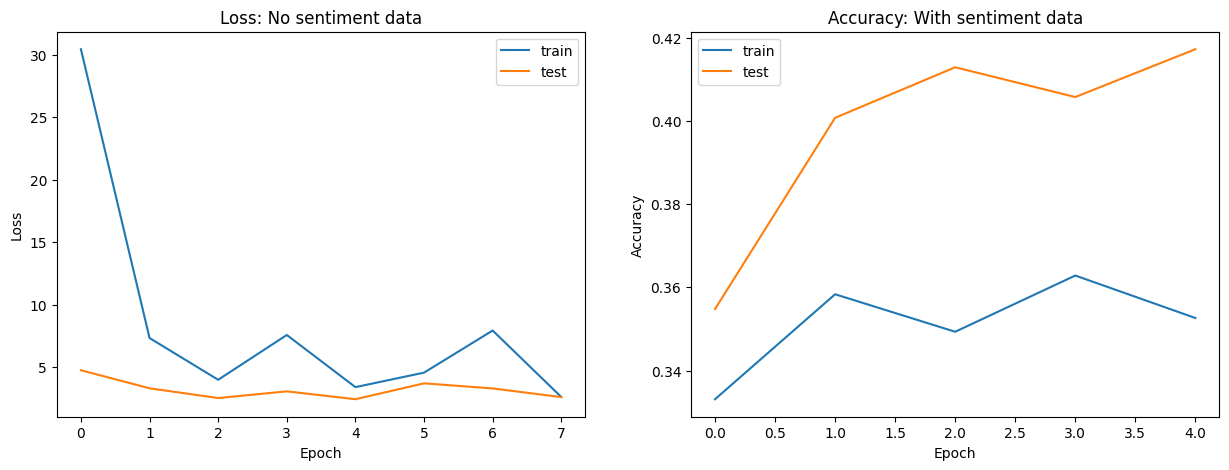

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(lstm_results_without_sentiment["loss"], label="train")
ax[0].plot(lstm_results_without_sentiment["val_loss"], label="test")
ax[0].set_title("Loss: No sentiment data")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(lstm_results_with_sentiment["accuracy"], label="train")
ax[1].plot(lstm_results_with_sentiment["val_accuracy"], label="test")
ax[1].set_title("Accuracy: With sentiment data")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.savefig("./results/lstm_results.png")
plt.show()

In [ ]:
full_yf_data = pl.concat(list(yf_dfs.values()))
full_yf_data.select([
    pl.col("Date").max().alias("max_date"),
    pl.col("Date").min().alias("min_date"),
])